# Custom Actor-Critic implementation and evaluation

## List of Contents

### Provided classes
- [`default_params()`](#default_params) this dictionary defines the default hyper-parameters
- [`TransitionBatch`](#TransitionBatch) the basic class to summarize transitions and build an experience replay buffer.
- [`Runner`](#Runner) interacts with one environment
- [`MultiRunner`](#MultiRunner) runs multiple `Runner` in parallel
- [`QController`](#QController) translates the model outputs into greedy actions
- [`ACController`](#ACController) interprets the first model outputs as logits of a softmax
- [`EpsilonGreedyController`](#EpsilonGreedyController) performs epsilon-greedy exploration
- [`ReinforceLearner`](#ReinforceLearner) trains the model with the REINFORCE algorithm
- [`Experment`](#Experiment) encapsulates and executes a single experiment
- [`ActorCriticExperiment`](#ActorCriticExperiment) performs online Q-learning



### Exercises
- [Q4.3a) Run REINFORCE](#q1)
- [Q4.3b) Extend REINFORCE with a bias function](#q2)
- [Q4.3c) Extend REINFORCE to the vanilla Actor-Critic algorithm](#q3)
- [Q4.3d) Extend the Actor-Critic algorithm to off-policy learning](#q4)
- [Q4.3e) Implement PPO clipping for off-policy learning](#q5)

In [1]:
# Pytorch and tools
import torch as th
from torch import Tensor, LongTensor
from torch.utils.data import DataLoader
import numpy as np
from copy import deepcopy
import numbers
from datetime import datetime
# Multi-threading
import threading
# Plotting
from IPython import display
import matplotlib.pyplot as plt
import pylab as pl
# Reinforcement learning
import gym
import cv2

This dictionary defines the default hyper-paramerters that you will use in your experiments. <a id=default_params></a>

In [2]:
def default_params():
    """ These are the default parameters used int eh framework. """
    return {# Debugging outputs and plotting during training
            'plot_frequency': 10,             # plots a debug message avery n steps
            'plot_train_samples': True,       # whether the x-axis is env.steps (True) or episodes (False)
            'print_when_plot': True,          # prints debug message if True
            'print_dots': False,              # prints dots for every gradient update
            # Environment parameters
            'env': 'CartPole-v0',             # the environment the agent is learning in
            'run_steps': 2048,                # samples whole episodes if run_steps <= 0
            'max_episode_length': 200,        # maximum number of steps per episode
            # Runner parameters
            'max_episodes': int(1E6),         # experiment stops after this many episodes
            # 'max_episodes': 1000,         # experiment stops after this many episodes
            'max_steps': int(2E6),            # experiment stops after this many steps
            # 'max_steps': 10000,            # experiment stops after this many steps
            'multi_runner': True,             # uses multiple runners if True
            'parallel_environments': 4,       # number of parallel runners  (only if multi_runner==True)
            # Exploration parameters
            'epsilon_anneal_time': int(2),    # exploration anneals epsilon over these many steps
            'epsilon_finish': 0.1,            # annealing stops at (and keeps) this epsilon
            'epsilon_start': 1,               # annealing starts at this epsilon
            # Optimization parameters
            'lr': 5E-4,                       # learning rate of optimizer
            'gamma': 0.99,                    # discount factor gamma
            'mini_batch_size': 200,               # number of transitions in a mini-batch
            'batch_size': 500,               # number of transitions in a mini-batch
            'grad_norm_clip': 1,              # gradent clipping if grad norm is larger than this
            # Actor-critic parameters
            'value_loss_param': 0.1,          # governs the relative impact of the value relative to policy loss
            'advantage_bias': True,           # whether the advantages have the value as bias
            'advantage_bootstrap': True,      # whether advantages use bootstrapping (alternatively: returns)
            'offpolicy_iterations': 0,        # how many off-policy iterations are performed
            'value_targets': 'returns',       # either 'returns' or 'td' as regression targets of the value function
            # PPO parameters
            'ppo_clipping': True,             # whether we use the PPO loss
            'ppo_clip_eps': 0.1,              # the epsilon for the PPO loss

            'states_shape': (1,),  # Amount of states
            'num_actions': 5,       # delay between the two stacked observations
           }

`TransitionBatches` are dictionaries of variables, e.g. states or actions, that are saved in contiguous Tensors. <a id=TransitionBatch></a>

In [3]:
# Same as in exercise sheet 3
class TransitionBatch:
    """ Simple implementation of a batchof transitionsm (or another dictionary-based tensor structure).
        Read and write operations are thread-safe, but the iterator is not (you cannot interate
        over the same TransitionBatch in two threads at the same time). """
    def __init__(self, max_size, transition_format, batch_size=32):
        self.lock = threading.Lock()
        self.indices = []
        self.size = 0
        self.first = 0
        self.max_size = max_size
        self.batch_size = batch_size
        self.dict = {}
        for key, spec in transition_format.items():
            self.dict[key] = th.zeros([max_size, *spec[0]], dtype=spec[1])
            
    def _clone_empty_batch(self, max_size=None, batch_size=None):
        """ Clones this TransitionBatch without cloning the data. """
        max_size = self.max_size if max_size is None else max_size
        batch_size = self.batch_size if batch_size is None else batch_size
        return TransitionBatch(max_size=max_size, transition_format={}, batch_size=batch_size)
        
    def __getitem__(self, key):
        """ Access the TransitionBatch with the [] operator. Use as key either 
            - the string name of a variable to get the full tensor of that variable,
            - a slice to get a time-slice over all variables in the batch,
            - a LongTensor that selects a subset of indices for all variables in the batch. """
        # Return the entry of the transition called "key"
        if isinstance(key, str): 
            return self.dict[key]
        # Return a slice of the batch
        if isinstance(key, slice):
            key = slice(0 if key.start is None else key.start, self.size if key.stop is None else key.stop,
                        1 if key.step is None else key.step)
            self.lock.acquire()
            try:
                batch = self._clone_empty_batch()
                batch.size = (key.stop - key.start) // key.step 
                for k, v in self.dict.items():
                    batch.dict[k] = v[key] 
            finally: self.lock.release()
            return batch
        # Collect and return a set of transitions specified by the LongTensor "key" 
        if isinstance(key, th.Tensor):
            self.lock.acquire()
            try:
                batch = self._clone_empty_batch(max_size=key.shape[0])
                batch.size = key.shape[0]
                for k, v in self.dict.items():
                    key = key.view(batch.size, *[1 for _ in range(len(v.shape[1:]))])
                    batch.dict[k] = v.gather(dim=0, index=key.expand(batch.size, *v.shape[1:]))
            finally: self.lock.release()
            return batch
        return None
    
    def get_first(self):
        """ Returns a batch of the oldest entries of all variables. """
        batch = self._clone_empty_batch(max_size=1)
        self.lock.acquire()
        try:
            batch.size = 1
            for k, v in self.dict.items():
                batch.dict[k] = v[self.first].unsqueeze(dim=0)
        finally: self.lock.release()
        return batch    
    
    def get_last(self):
        """ Returns a batch of the newest entries of all variables. """
        batch = self._clone_empty_batch(max_size=1)
        self.lock.acquire()
        try:
            batch.size = 1
            for k, v in self.dict.items():
                batch.dict[k] = v[(self.first + self.size - 1) % self.size].unsqueeze(dim=0)
        finally: self.lock.release()
        return batch
    
    def add(self, trans:dict):
        """ Adding transition dictionaries, which can contain Tensors of arbitrary length. """
        if isinstance(trans, TransitionBatch):
            trans = trans.dict
        # Add all data in the dict
        self.lock.acquire()
        try:
            n = 0
            idx = None
            for k, v in trans.items():
                if idx is None:
                    n = v.shape[0]
                    idx = th.LongTensor([(self.first + self.size + i) % self.max_size for i in range(n)])
                else:
                    assert n == v.shape[0], 'all tensors in a transition need to have the same batch_size'
                idx = idx.view(idx.shape[0], *[1 for _ in range(len(v.shape) - 1)])
                self.dict[k].scatter_(dim=0, index=idx.expand_as(v), src=v)
            # Increase the size (and handle overflow)
            self.size += n
            if self.size > self.max_size:
                self.first = (self.first + n) % self.max_size
                self.size = self.max_size
        finally: self.lock.release()
        return self
            
    def trim(self):
        """ Reduces the length of the max_size to its actual size (in-place). Returns self. """
        self.lock.acquire()
        try:
            for k, v in self.dict.items():
                self.dict[k] = v[:self.size]
            self.max_size = self.size
        finally: self.lock.release()
        return self
    
    def replace(self, batch, index=0):
        """ Replaces parts of this batch with another batch (which must be smaller). """
        self.lock.acquire()
        try:
            #assert batch.max_size <= self.max_size - index, "Replacement is larger then target area in batch."
            assert batch.size <= self.max_size - index, "Replacement is larger then target area in batch."
            for k, v in batch.dict.items():
                if batch.size < batch.max_size:
                    v = v[:batch.size]
                self.dict[k][index:(index + batch.max_size)] = v    
        finally: self.lock.release()
    
    def sample(self):
        """ Samples a random mini-batch from the batch. """
        return self[th.randint(high=self.size, size=(self.batch_size,1))]
            
    def __len__(self): 
        """ Returns the length of the batch. """
        return self.size
    
    def __iter__(self):  
        """ Initializes an iterator over the batch. """
        self.indices = list(range(self.size))
        np.random.shuffle(self.indices)
        return self
    
    def __next__(self):  
        """ Iterates through batch, returns list of contiguous tensors. """
        if len(self.indices) == 0: raise StopIteration
        size = min(self.batch_size, len(self.indices))
        batch = self[th.LongTensor(self.indices[-size:])]
        self.indices = self.indices[:-size]
        return batch

`Runner` implements a simple runner class that uses a controller to interact with the environment by calling `run()` or `run_episode()`. <a id=Runner></a>

In [4]:
# Same as in exercise sheet 3
class Runner:
    """ Implements a simple single-thread runner class. """
    def __init__(self, controller, params={}, exploration_step=1):
        self.env = gym.make(params.get('env', 'CartPole-v0'))
        self.cont_actions = isinstance(self.env.action_space, gym.spaces.Box)
        self.controller = controller
        self.epi_len = params.get('max_episode_length', self.env._max_episode_steps)
        self.gamma = params.get('gamma', 0.99)
        self.use_pixels = params.get('pixel_observations', False)
        if self.use_pixels:
            self.grayscale = params.get('pixel_grayscale', True)
            self.add_last_obs = params.get('pixel_add_last_obs', False)
            self.last_obs_delay = params.get('pixel_last_obs_delay', 4)
            n_colors = 1 if self.grayscale else 3
            n_feats = n_colors * (2 if self.add_last_obs else 1)
            resolution = params.get('pixel_resolution', (25, 25))
            self.state_shape = (n_feats, *resolution)
            self.last_observations = TransitionBatch(max_size=self.last_obs_delay, 
                                                     transition_format={'img': ((n_colors, *resolution), th.float32)})
        else:
            self.state_shape = self.env.observation_space.shape
        # Set up current state and time step
        self.sum_rewards = 0
        self.state = None
        self.time = 0
        self._next_step()

    def close(self):
        """ Closes the underlying environment. Should always when ending an experiment. """
        self.env.close()
    
    def transition_format(self):
        """ Returns the format of transtions: a dictionary of (shape, dtype) entries for each key. """
        return {'actions': ((1,), th.long),
                'states': (self.state_shape, th.float32),
                'next_states': (self.state_shape, th.float32),
                'rewards': ((1,),  th.float32),
                'dones': ((1,), th.bool),
                'returns': ((1,), th.float32)}
    
    def _wrap_transition(self, s, a, r, ns, d):
        """ Takes a transition and returns a corresponding dictionary. """
        trans = {}
        form = self.transition_format()
        for key, val in [('states', s), ('actions', a), ('rewards', r), ('next_states', ns), ('dones', d)]:
            if not isinstance(val, th.Tensor): 
                if isinstance(val, numbers.Number) or isinstance(val, bool): val = [val]
                val = th.tensor(val, dtype=form[key][1])
            if len(val.shape) < len(form[key][0]) + 1: val = val.unsqueeze(dim=0)
            trans[key] = val
        return trans
    
    def _pixel_observation(self, reset=False):
        """ Returns the pixel-observation fo the current state. Opens extra window for rendering. """
        img = self.env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=self.state_shape[1:], interpolation=cv2.INTER_CUBIC)
        img = th.from_numpy(img.astype(np.float32) / 255).transpose(dim0=0, dim1=2).unsqueeze(dim=0)
        if self.grayscale: img = img.mean(dim=1, keepdim=True)
        if self.add_last_obs:
            if reset: self.last_observations.size = 0
            if self.last_observations.size < self.last_observations.max_size:
                obs = img * 0
            else:
                obs = self.last_observations.get_first()['img'].clone()
            self.last_observations.add({'img': img})
            img = th.cat([obs, img], dim=1)
        return img
    
    def _run_step(self, a):
        """ Make a step in the environment (and update internal bookeeping) """
        ns, r, d, _ = self.env.step(a.item())
        self.sum_rewards += r
        if self.use_pixels: ns = self._pixel_observation()
        return r, ns, d
    
    def _next_step(self, done=True, next_state=None):
        """ Switch to the next time-step (and update internal bookeeping) """
        self.time = 0 if done else self.time + 1
        if done:
            self.sum_rewards = 0
            self.state = self.env.reset()
            if self.use_pixels: self.state = self._pixel_observation(reset=True)
        else:
            self.state = next_state
        
    
    def run(self, n_steps, transition_buffer=None, trim=True, return_dict=None):
        """ Runs n_steps in the environment and stores them in the trainsition_buffer (newly created if None).
            If n_steps <= 0, stops at the end of an episode and optionally trins the transition_buffer.
            Returns a dictionary containing the transition_buffer and episode statstics. """
        my_transition_buffer = TransitionBatch(n_steps if n_steps > 0 else self.epi_len, self.transition_format())
        time, episode_start, episode_lengths, episode_rewards = 0, 0, [], []
        max_steps = n_steps if n_steps > 0 else self.epi_len
        for t in range(max_steps):
            # One step in the envionment
            a = self.controller.choose(self.state)
            r, ns, d = self._run_step(a)
            terminal = d and self.time < self.epi_len - 1
            my_transition_buffer.add(self._wrap_transition(self.state, a, r, ns, terminal)) 
            if t == self.epi_len - 1: d = True
            # Compute discounted returns if episode has ended or max_steps has been reached
            if d or t == (max_steps - 1):
                my_transition_buffer['returns'][t] = my_transition_buffer['rewards'][t]
                for i in range(t - 1, episode_start - 1, -1):
                    my_transition_buffer['returns'][i] = my_transition_buffer['rewards'][i] \
                                                         + self.gamma * my_transition_buffer['returns'][i + 1]
                episode_start = t + 1
            # Remember statistics and advance (potentially initilaizing a new episode)
            if d:
                episode_lengths.append(self.time + 1)
                episode_rewards.append(self.sum_rewards)
            self._next_step(done=d, next_state=ns)
            time += 1
            # If n_steps <= 0, we return after one episode (trimmed if specified)
            if d and n_steps <= 0: 
                my_transition_buffer.trim()
                break
        # Add the sampled transitions to the given transition buffer
        transition_buffer = my_transition_buffer if transition_buffer is None \
                            else transition_buffer.add(my_transition_buffer)
        if trim: transition_buffer.trim()
        # Return statistics (mean reward, mean length and environment steps)
        if return_dict is None: return_dict = {}
        return_dict.update({'buffer': transition_buffer,
                            'episode_reward': None if len(episode_rewards) == 0 else np.mean(episode_rewards),
                            'episode_length': None if len(episode_lengths) == 0 else np.mean(episode_lengths),
                            'env_steps': time})
        return return_dict
        
    def run_episode(self, transition_buffer=None, trim=True, return_dict=None):
        """ Runs one episode in the environemnt. 
            Returns a dictionary containing the transition_buffer and episode statstics. """
        return self.run(0, transition_buffer, trim, return_dict)

`MultiRunner` runs a number of `Runner` instances in parallel. <a id=MultiRunner></a>

In [5]:
# Same as in exercise sheet 3
class MultiRunner:
    """ Simple class that runs multiple Runner objects in parallel and merges their outputs. """
    def __init__(self, controller, params={}):
        self.workers = []
        self.runners = []
        n = params.get('parallel_environments', 1)
        for _ in range(n):
            self.runners.append(Runner(controller=controller, params=params))
            
    def transition_format(self):
        """ Same transition-format as underlying Runners. """
        return self.runners[0].transition_format()
    
    def close(self):
        """ Closes the underlying environment. Should always when ending an experiment. """
        # Join all workers
        for w in self.workers:
            w.join()
        # Exit all environments
        for r in self.runners:
            r.close()
    
    def fork(self, target, common_args=None, specific_args=None):
        """ Executes the function "target" on all runners. "common_args" is a dictionary of 
            arguments that are passed to all runners, "specific_args" is a list of 
            dictionaries that contain individual parameters for each runner. """ 
        # Fork all runners
        self.workers = []
        for i, r in enumerate(self.runners):
            r_args = [] if specific_args is None else [arg[i] for arg in specific_args]
            self.workers.append(threading.Thread(target=target, args=(r, *common_args, *r_args)))
            self.workers[-1].start()
        # Join all runners
        for w in self.workers:
            w.join()
    
    def run(self, n_steps, transition_buffer=None, trim=True):
        """ Runs n_steps, split amongst runners, and stores them in the trainsition_buffer (newly created if None).
            If n_steps <= 0, stops at the end of an episode and optionally trims the transition_buffer.
            Returns a dictionary containing the transition_buffer and episode statstics. """
        n_steps = n_steps // len(self.runners)
        if transition_buffer is None:
            buffer_len = len(self.runners) * (n_steps if n_steps > 0 else self.runners[0].epi_len)
            transition_buffer = TransitionBatch(buffer_len, self.runners[0].transition_format())
        return_dicts = [{} for _ in self.runners]
        self.fork(target=Runner.run, common_args=(n_steps, transition_buffer, False), specific_args=(return_dicts,))
        if trim: transition_buffer.trim()
        rewards = [d['episode_reward'] for d in return_dicts if d['episode_reward'] is not None]
        lengths = [d['episode_length'] for d in return_dicts if d['episode_reward'] is not None]
        return {'buffer': transition_buffer, 
                'episode_reward': np.mean(rewards) if len(rewards) > 0 else None,
                'episode_length': np.mean(lengths) if len(lengths) > 0 else None,
                'env_steps': len(transition_buffer)}

    def run_episode(self, transition_buffer=None, trim=True):
        """ Runs one episode in the environemnt. 
            Returns a dictionary containing the transition_buffer and episode statstics. """
        return self.run(0, transition_buffer, trim)

A `QController` translates model responses into actions. Call `choose()` to select actions or `probabilities()` to get the probabilities with which the controller would choose the actions. <a id=QController></a>

In [6]:
# Same as in exercise sheet 3
class QController:
    """ Controller for Q-value functions, synchronizes the model calls. """
    def __init__(self, model, num_actions=None, params={}):
        self.lock = threading.Lock()
        self.num_actions = model[-1].out_features if num_actions is None else num_actions
        self.model = model
        
    def copy(self):
        """ Shallow copy of this controller that does not copy the model. """
        return QController(model=self.model, num_actions=self.num_actions)
        
    def parameters(self):
        """ Returns a generator of the underlying model parameters. """
        return self.model.parameters()
    
    def sanitize_inputs(self, observation, **kwargs):
        """ Casts numpy arrays as Tensors. """
        if isinstance(observation, np.ndarray):
            observation = th.Tensor(observation).unsqueeze(dim=0)
        return observation
                
    def choose(self, observation, **kwargs):
        """ Returns the greedy actions the agent would choose when facing an "observation". """
        self.lock.acquire()
        try: 
            mx = self.model(self.sanitize_inputs(observation))
            if mx.shape[-1] > self.num_actions: mx = mx[:, :self.num_actions]
        finally: self.lock.release()
        return th.max(mx, dim=-1)[1]

    def probabilities(self, observation, **kwargs):
        """ Returns the probabilities with which the agent would choose actions (here one-hot because greedy). """
        self.lock.acquire()
        try: 
            mx = self.model(self.sanitize_inputs(observation))
            if mx.shape[-1] > self.num_actions: mx = mx[:, :self.num_actions]
        finally: self.lock.release()
        return th.zeros(*mx.shape).scatter_(dim=-1, index=th.max(mx, dim=-1)[1].unsqueeze(dim=-1), src=th.ones(1, 1))

An `ACController` overwrites the `QController` and interpretes the model output as logits of a softmax policy (followed by additional outputs, like a value head, that are of no interest to the contoller).  <a id=ACController></a>

In [7]:
class ACController (QController):
    """ A controller that interprets the first num_actions model outputs as logits of a softmax distribution. """
    def probabilities(self, observation, precomputed=False, **kwargs):
        self.lock.acquire()
        try: mx = observation if precomputed else self.model(self.sanitize_inputs(observation))[:, :self.num_actions] 
        finally: self.lock.release()
        return th.nn.functional.softmax(mx, dim=-1)

    def choose(self, observation, **kwargs):
        return th.distributions.Categorical(probs=self.probabilities(observation, **kwargs)).sample()

An `EpsilonGreedyController` is a controller that autonomously anneals an expsilon greedy exploration strategy. <a id=EpsilonGreedyController></a>

In [8]:
# Same as in exercise sheet 3
class EpsilonGreedyController:
    """ A wrapper that makes any controller into an epsilon-greedy controller. 
        Keeps track of training-steps to decay exploration automatically. """
    def __init__(self, controller, params={}, exploration_step=1):
        self.controller = controller
        self.num_actions = controller.num_actions
        self.max_eps = params.get('epsilon_start', 1.0)
        self.min_eps = params.get('epsilon_finish', 0.05)
        self.anneal_time = int(params.get('epsilon_anneal_time', 10000) / exploration_step)
        self.num_decisions = 0
    
    def epsilon(self):
        """ Returns current epsilon. """
        return max(1 - self.num_decisions / (self.anneal_time - 1), 0) \
                * (self.max_eps - self.min_eps) + self.min_eps
    
    def choose(self, observation, increase_counter=True, **kwargs):
        """ Returns the (possibly random) actions the agent takes when faced with "observation".
            Decays epsilon only when increase_counter=True". """
        eps = self.epsilon()
        if increase_counter: self.num_decisions += 1
        if np.random.rand() < eps: 
            return th.randint(self.controller.num_actions, (1,), dtype=th.long)
        else: 
            return self.controller.choose(observation, **kwargs)
    
    def probabilities(self, observation, **kwargs):
        """ Returns the probabilities with which the agent would choose actions. """
        eps = self.epsilon()
        return eps * th.ones(1, 1) / self.num_actions + \
               (1 - eps) * self.controller.probabilities(observation, **kwargs) 

A `ReinforceLearner` is a learner class that trains an actor-critic model with the REINFORCE algorithm. <a id=ReinforceLearner></a>

In [9]:
class ReinforceLearner:
    """ A learner that performs a version of REINFORCE. """
    def __init__(self, model, controller=None, params={}):
        self.model = model
        self.controller = controller
        self.value_loss_param = params.get('value_loss_param', 1)
        self.offpolicy_iterations = params.get('offpolicy_iterations', 0)
        self.all_parameters = list(model.parameters())
        self.optimizer = th.optim.Adam(self.all_parameters, lr=params.get('lr', 5E-4))
        self.grad_norm_clip = params.get('grad_norm_clip', 10)
        self.compute_next_val = False  # whether the next state's value is computed
        self.old_pi = None  # this variable can be used for your PPO implementation
        
    def set_controller(self, controller):
        """ This function is called in the experiment to set the controller. """
        self.controller = controller
    
    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        return batch['returns']
    
    def _value_loss(self, batch, values=None, next_values=None):
        """ Computes the value loss (if there is one). """
        return 0
    
    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        return -(advantages.detach() * pi.log()).mean()

    def train(self, batch):
        assert self.controller is not None, "Before train() is called, a controller must be specified. "
        self.model.train(True)
        self.old_pi, loss_sum = None, 0.0
        for _ in range(1 + self.offpolicy_iterations):
            # Compute the model-output for given batch
            out = self.model(batch['states'])   # compute both policy and values
            val = out[:, -1].unsqueeze(dim=-1)  # last entry are the values
            next_val = self.model(batch['next_states'])[:, -1].unsqueeze(dim=-1) if self.compute_next_val else None
            pi = self.controller.probabilities(out[:, :-1], precomputed=True).gather(dim=-1, index=batch['actions'])
            # Combine policy and value loss
            loss = self._policy_loss(pi, self._advantages(batch, val, next_val)) \
                    + self.value_loss_param * self._value_loss(batch, val, next_val)
            # Backpropagate loss
            self.optimizer.zero_grad()
            loss.backward()
            grad_norm = th.nn.utils.clip_grad_norm_(self.all_parameters, self.grad_norm_clip)
            self.optimizer.step()
            loss_sum += loss.item()
        return loss_sum

An `Experiment` is an abstract class that starts and maintains a single learning experiment (i.e. random seed). The experiment is started using `run()` and can be interrupted at any time using `close()`. Afterwards the experiment can be restarted at any time calling `run()` again. <a id=Experiment></a>

In [10]:
# Same as in exercise sheet 3
# import seaborn as sns
class Experiment:
    """ Abstract class of an experiment. Contains logging and plotting functionality."""
    def __init__(self, params, model, **kwargs):
        self.params = params
        self.plot_frequency = params.get('plot_frequency', 10)
        self.plot_train_samples = params.get('plot_train_samples', True)
        self.print_when_plot = params.get('print_when_plot', False)
        self.print_dots = params.get('print_dots', False)
        self.episode_returns = []
        self.episode_lengths = []
        self.episode_losses  = []
        self.env_steps = []
        self.total_run_time = 0.0
        
    def plot_training(self, update=False):
        """ Plots logged training results. Use "update=True" if the plot is continuously updated
            or use "update=False" if this is the final call (otherwise there will be double plotting). """ 
        # Smooth curves
        window = max(int(len(self.episode_returns) / 3), 1)
        if len(self.episode_losses) < window + 2: return
        returns = np.convolve(self.episode_returns, np.ones(window)/window, 'valid')
        lengths = np.convolve(self.episode_lengths, np.ones(window)/window, 'valid')
        losses = np.convolve(self.episode_losses, np.ones(window)/window, 'valid')
        env_steps = np.convolve(self.env_steps, np.ones(window)/window, 'valid')
        # Determine x-axis based on samples or episodes
        if self.plot_train_samples:
            x_returns = env_steps
            x_losses = env_steps[(len(env_steps) - len(losses)):]
        else:
            x_returns = [i + window for i in range(len(returns))]
            x_losses = [i + len(returns) - len(losses) + window for i in range(len(losses))]
        # Create plot
        colors = ['b', 'g', 'r']
        # fig.set_size_inches(16, 4)
        plt.clf()
        # Plot the losses in the left subplot
        # pl.subplot(1, 3, 1)
        plt.plot(x_returns, returns, colors[0])
        plt.xlabel('Environment steps' if self.plot_train_samples else 'Batch episodes')
        plt.ylabel('Episode return')
        # plt.title('Average training score for CartPole with off-PAC with PPO')
        # Plot the episode lengths in the middle subplot
        # ax = pl.subplot(1, 3, 2)
        # ax.plot(env_steps, lengths, colors[0])
        # ax.set_xlabel('environment steps' if self.plot_train_samples else 'episodes')
        # ax.set_ylabel('episode length')
        # Plot the losses in the right subplot
        # ax = pl.subplot(1, 3, 3)
        # ax.plot(x_losses, losses, colors[0])
        # ax.set_xlabel('environment steps' if self.plot_train_samples else 'episodes')
        # ax.set_ylabel('loss')
        # dynamic plot update
        display.clear_output(wait=True)
        if update:
            display.display(pl.gcf())
    
    def close(self):
        """ Frees all allocated runtime ressources, but allows to continue the experiment later. 
            Calling the run() method after close must be able to pick up the experiment where it was. """
        pass
    
    def run(self):
        """ Starts (or continues) the experiment. """
        assert False, "You need to extend the Expeirment class and override the method run(). "

`ActorCriticExperiment` performs policy gradient learning using `ReinforceLearner`. One can specify another learner, which you will do in later exercises. <a id=ActorCriticExperiment></a>

In [11]:
class ActorCriticExperiment (Experiment):
    def __init__(self, params, model, learner=None, **kwargs):
        super().__init__(params, model, **kwargs)
        self.max_episodes = params.get('max_episodes', int(1E6))
        self.max_batch_episodes = params.get('max_batch_episodes', int(1E6))
        self.max_steps = params.get('max_steps', int(1E9))
        self.grad_repeats = params.get('grad_repeats', 1)
        self.batch_size = params.get('batch_size', 1024)
        self.controller = ACController(model, num_actions=gym.make(params['env']).action_space.n, params=params)
        self.controller = EpsilonGreedyController(controller=self.controller, params=params)
        self.runner = MultiRunner(self.controller, params=params) if params.get('multi_runner', True) \
                      else Runner(self.controller, params=params)
        self.learner = ReinforceLearner(model, params=params) if learner is None else learner
        self.learner.set_controller(self.controller)
        self.opposd = params.get('opposd', False)
        self.opposd_iterations = params.get('opposd_iterations', 50)

    def close(self):
        """ Overrides Experiment.close() """
        self.runner.close()

    def run(self):
        """ Overrides Experiment.run() """
        # Plot past results if available
        if self.plot_frequency is not None and len(self.episode_losses) > 2:
            self.plot_training(update=True)
        # Run the experiment
        transition_buffer = TransitionBatch(self.batch_size, self.runner.transition_format(), self.batch_size)
        env_steps = 0 if len(self.env_steps) == 0 else self.env_steps[-1]
        for e in range(self.max_batch_episodes):
            # Run the policy for batch_size steps
            batch = self.runner.run(self.batch_size, transition_buffer)
            if self.opposd:
                # print('OK1')
                self.learner.reset_w_net()
                # print('OK2')
            env_steps += batch['env_steps']
            if batch['episode_length'] is not None:
                self.env_steps.append(env_steps)
                self.episode_lengths.append(batch['episode_length'])
                self.episode_returns.append(batch['episode_reward'])
            # Make a gradient update step
            loss = self.learner.train(batch['buffer'])
            self.episode_losses.append(loss)
            # Quit if maximal number of environment steps is reached
            if env_steps >= self.max_steps: break
            # Show intermediate results
            if self.print_dots:
                print('.', end='')
            if self.plot_frequency is not None and (e + 1) % self.plot_frequency == 0 \
                                               and len(self.episode_losses) > 2:
                self.plot_training(update=True)
                if self.print_when_plot:
                    print('Episode %u, 100-epi-return %.4g +- %.3g, length %u, loss %g' % 
                          (len(self.episode_returns), np.mean(self.episode_returns[-100:]), 
                           np.std(self.episode_returns[-100:]), np.mean(self.episode_lengths[-100:]), 
                           np.mean(self.episode_losses[-100:])))

In [12]:
class BatchActorCriticExperiment (Experiment):
    def __init__(self, params, model, learner=None, **kwargs):
        super().__init__(params, model, **kwargs)
        self.max_episodes = params.get('max_episodes', int(1E6))
        self.max_batch_episodes = params.get('max_batch_episodes', int(1E6))
        self.max_steps = params.get('max_steps', int(1E9))
        self.grad_repeats = params.get('grad_repeats', 1)
        self.batch_size = params.get('batch_size', 1e5)
        self.mini_batch_size = params.get('mini_batch_size', 200)
        self.controller = ACController(model, num_actions=gym.make(params['env']).action_space.n, params=params)
        self.controller = EpsilonGreedyController(controller=self.controller, params=params)
        self.runner = MultiRunner(self.controller, params=params) if params.get('multi_runner', True) \
                      else Runner(self.controller, params=params)
        self.learner = ReinforceLearner(model, params=params) if learner is None else learner
        self.learner.set_controller(self.controller)
        self.opposd = params.get('opposd', False)
        self.opposd_iterations = params.get('opposd_iterations', 50)

    def close(self):
        """ Overrides Experiment.close() """
        self.runner.close()

    def run(self):
        """ Overrides Experiment.run() """
        # Plot past results if available
        if self.plot_frequency is not None and len(self.episode_losses) > 2:
            self.plot_training(update=True)
        # Run the experiment
        transition_buffer = TransitionBatch(self.batch_size, self.runner.transition_format(), self.mini_batch_size)
        batch = self.runner.run(self.batch_size, transition_buffer)
        env_steps = 0 if len(self.env_steps) == 0 else self.env_steps[-1]
        for e in range(self.max_batch_episodes):
            # Make a gradient update step
            loss = self.learner.train(batch)
            self.episode_losses.append(loss)
            # Quit if maximal number of environment steps is reached
            if env_steps >= self.max_steps: break
            # Show intermediate results
            if self.print_dots:
                print('.', end='')
            if self.plot_frequency is not None and (e + 1) % self.plot_frequency == 0 \
                                               and len(self.episode_losses) > 2:
                self.plot_training(update=True)
                if self.print_when_plot:
                    print('Episode %u, 100-epi-return %.4g +- %.3g, length %u, loss %g' %
                          (len(self.episode_returns), np.mean(self.episode_returns[-100:]),
                           np.std(self.episode_returns[-100:]), np.mean(self.episode_lengths[-100:]),
                           np.mean(self.episode_losses[-100:])))

## Q4.3a) Run the given online REINFORCE algorithm <a id=q1></a>

In [13]:
online_experiments = []
max_batch_episodes = 2000

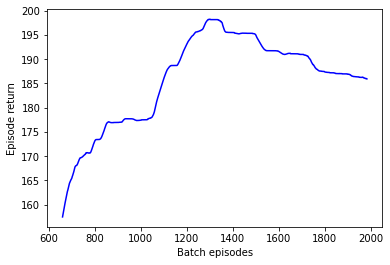

In [14]:
# Q4.3a) Run the given Online Q-learning algorithm without target networks or experience replay

# Executing this code-block defines a new experiment
params = default_params()
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(max_batch_episodes)
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=ReinforceLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()
return_dict = {}
return_dict.update({'model' : 'RL',
                            'experiment': experiment})
online_experiments = np.append(online_experiments, return_dict)

## Q4.3b) Add a value bias to REINFORCE <a id=q2></a>

In [15]:
class BiasedReinforceLearner (ReinforceLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.value_criterion = th.nn.MSELoss()
        self.advantage_bias = params.get('advantage_bias', True)
        self.value_targets = params.get('value_targets', 'returns')
        self.gamma = params.get('gamma')
        self.compute_next_val = (self.value_targets == 'td')
    
    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        advantages = batch['returns']
        if self.advantage_bias:
            advantages -= values
        return advantages
    
    def _value_loss(self, batch, values=None, next_values=None):
        """ Computes the value loss (if there is one). """
        targets = None
        if self.value_targets == 'returns':
            targets = batch['returns']
        elif self.value_targets == 'td':
            targets = batch['rewards'] + self.gamma * (~batch['dones'] * next_values)
        return self.value_criterion(values, targets.detach())


# # Executing this code-block defines a new experiment
# params = default_params()
# env = gym.make(params['env'])
# n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
# # The model has n_action policy heads and one value head
# model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
#                          th.nn.Linear(128, 512), th.nn.ReLU(),
#                          th.nn.Linear(512, 128), th.nn.ReLU(),
#                          th.nn.Linear(128, n_actions + 1))
# experiment = ActorCriticExperiment(params, model, learner=BiasedReinforceLearner(model, params=params))
#
# # Re-executing this code-block picks up the experiment where you left off
# try:
#     experiment.run()
# except KeyboardInterrupt:
#     experiment.close()
# experiment.plot_training()

## Q4.3c) Add an advantage to RENFORCE <a id=q3></a>

In [16]:
class ActorCriticLearner (BiasedReinforceLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.advantage_bootstrap = params.get('advantage_bootstrap', True)
        self.compute_next_val = self.compute_next_val or self.advantage_bootstrap
    
    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        advantages = None
        if self.advantage_bootstrap: 
            advantages = batch['rewards'] + self.gamma * (~batch['dones'] * next_values)
        else:
            advantages = batch['returns']
        if self.advantage_bias: 
            advantages = advantages - values
        return advantages
    

# # Executing this code-block defines a new experiment
# params = default_params()
# env = gym.make(params['env'])
# n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
# # The model has n_action policy heads and one value head
# model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
#                          th.nn.Linear(128, 512), th.nn.ReLU(),
#                          th.nn.Linear(512, 128), th.nn.ReLU(),
#                          th.nn.Linear(128, n_actions + 1))
# experiment = ActorCriticExperiment(params, model, learner=ActorCriticLearner(model, params=params))
#
# # Re-executing this code-block picks up the experiment where you left off
# try:
#     experiment.run()
# except KeyboardInterrupt:
#     experiment.close()
# experiment.plot_training()

In [17]:
# params = default_params()
# params['plot_train_samples'] = False
# params['plot_frequency'] = 4
# params['max_batch_episodes'] = int(max_batch_episodes)
# env = gym.make(params['env'])
# n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
# # The model has n_action policy heads and one value head
# model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
#                          th.nn.Linear(128, 512), th.nn.ReLU(),
#                          th.nn.Linear(512, 128), th.nn.ReLU(),
#                          th.nn.Linear(128, n_actions + 1))
# experiment = ActorCriticExperiment(params, model, learner=BiasedReinforceLearner(model, params=params))
#
# # Re-executing this code-block picks up the experiment where you left off
# try:
#     experiment.run()
# except KeyboardInterrupt:
#     experiment.close()
# experiment.plot_training()
# return_dict = {}
# return_dict.update({'model' : 'RL+advantage',
#                             'experiment': experiment})
# online_experiments = np.append(online_experiments, return_dict)

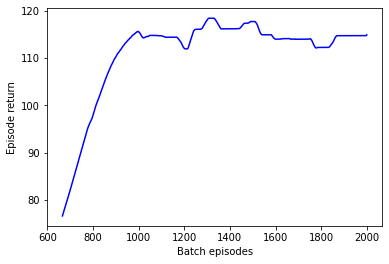

In [18]:
# Executing this code-block defines a new experiment
params = default_params()
# params['offpolicy_iterations'] = 128
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(max_batch_episodes)
params['batch_size'] = 1000
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]

# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=ActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()
return_dict = {}
return_dict.update({'model' : 'AC',
                            'experiment': experiment})
online_experiments = np.append(online_experiments, return_dict)

In [19]:
class OffpolicyActorCriticLearner (ActorCriticLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)

    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        if self.old_pi is None:
            self.old_pi = pi  # remember on-policy probabilities for off-policy losses
            # Return the defaul on-policy loss
            return super()._policy_loss(pi, advantages)
        else:
            # The loss for off-policy data
            ratios = pi / self.old_pi.detach()
            return -(advantages.detach() * ratios).mean()

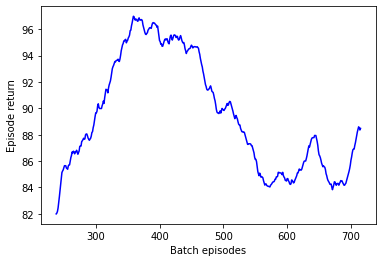

In [20]:
# Executing this code-block defines a new experiment
params = default_params()
params['offpolicy_iterations'] = 128
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(max_batch_episodes)
params['batch_size'] = 1000

# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()
return_dict = {}
return_dict.update({'model' : 'OFFPAC',
                            'experiment': experiment})
online_experiments = np.append(online_experiments, return_dict)

## Q4.3e) Add PPO clipping to the off-policy actor critic  <a id=q5></a>

In [21]:
class PPOLearner (OffpolicyActorCriticLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.ppo_clipping = params.get('ppo_clipping', False)
        self.ppo_clip_eps = params.get('ppo_clip_eps', 0.2)

    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        if self.old_pi is None:
            # The loss for on-policy data does not change
            return super()._policy_loss(pi, advantages)
        else:
            # The loss for off-policy data
            ratios = pi / self.old_pi.detach()
            loss = advantages.detach() * ratios
            if self.ppo_clipping:
                # off-policy loss with PPO clipping
                ppo_loss = th.clamp(ratios, 1-self.ppo_clip_eps, 1+self.ppo_clip_eps) * advantages.detach()
                loss = th.min(loss, ppo_loss)
            return -loss.mean()


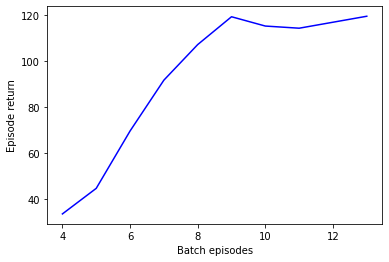

In [24]:

# Executing this code-block defines a new experiment
params = default_params()
params['offpolicy_iterations'] = 128
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(max_batch_episodes)
params['batch_size'] = 1000
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]

# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(), 
                         th.nn.Linear(128, 512), th.nn.ReLU(), 
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=PPOLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()
return_dict = {}
return_dict.update({'model' : 'PPO',
                            'experiment': experiment})
online_experiments = np.append(online_experiments, return_dict)

Text(0.5, 1.0, 'Cart-pole environment')

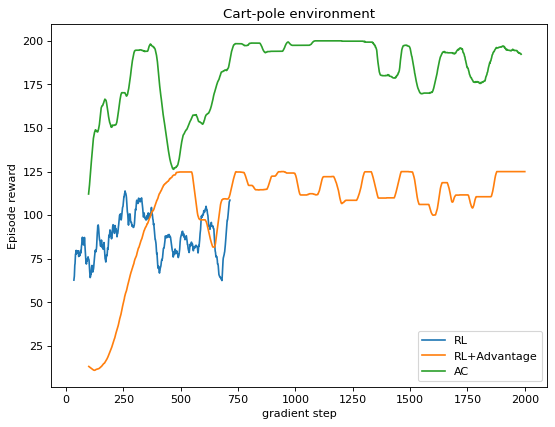

In [23]:
plt.figure(figsize=(8, 6), dpi=80)
i = 0

for exp in [online_experiments[2], online_experiments[1], online_experiments[0]]:
    window = max(int(len(exp['experiment'].episode_returns) / 20), 1)
    # if len(exp.episode_losses) < window + 2: return
    returns = np.convolve(exp['experiment'].episode_returns, np.ones(window) / window, 'valid')
    # Determine x-axis based on samples or episodes
    x_returns = [i + window for i in range(len(returns))]
    # plt.plot(x_returns, returns, label=exp['model'])
    plt.plot(x_returns, returns)
# plt.axhline(y=np.mean(heuristic_score), color='k', linestyle='--', label='Heuristic algorithm average score')
plt.xlabel('gradient step') # ENvironment interactions
plt.ylabel('Episode reward')
plt.legend(['RL', 'RL+Advantage', 'AC'])
# plt.legend()
plt.title('Cart-pole environment')

In [34]:
class OPPOSDLearner(OffpolicyActorCriticLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.num_actions = params.get('num_actions', 5)
        self.batch_size = params.get('batch_size')
        self.states_shape = params.get('states_shape')
        self.w_grad_norm_clip = params.get('grad_norm_clip', 10)
        self.pi_0 = 1 * th.ones(self.batch_size, 1) / self.num_actions
        self.w_model = th.nn.Sequential(th.nn.Linear(self.states_shape, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
        self.w_parameters = list(self.w_model.parameters())
        self.w_optimizer = th.optim.Adam(self.w_parameters, lr=params.get('lr', 5E-4))

    def train(self, batch):
        assert self.controller is not None, "Before train() is called, a controller must be specified. "
        self.model.train(True)
        loss_sum = 0.0
        # out = self.model(batch['states'])
        # self.pi_0 = self.controller.probabilities(out[:, :-1], precomputed=True).gather(dim=-1, index=batch['actions'])
        pi = None

        for it in range(1 + self.offpolicy_iterations):
            # Compute the model-output for given batch
            out = self.model(batch['states'])  # compute both policy and values
            val = out[:, -1].unsqueeze(dim=-1)  # last entry are the values
            next_val = self.model(batch['next_states'])[:, -1].unsqueeze(dim=-1) if self.compute_next_val else None
            pi = self.controller.probabilities(out[:, :-1], precomputed=True).gather(dim=-1, index=batch['actions'])
            ratio = pi.detach() / self.pi_0
            for _ in range(50):
                # batch_w = self.runner.run(self.batch_size, transition_buffer)
                batch_w = batch.sample()
                self.update_policy_distribution(batch_w, ratio)

            w = self.w_model(batch['states']).detach()
            w /= th.mean(w)
            # Combine policy and value loss
            loss = self._policy_loss(ratio * w, self._advantages(batch, val, next_val)) \
                   + self.value_loss_param * self._value_loss(batch, val, next_val)
            # Backpropagate loss
            self.optimizer.zero_grad()
            loss.backward()
            grad_norm = th.nn.utils.clip_grad_norm_(self.all_parameters, self.grad_norm_clip)
            self.optimizer.step()
            loss_sum += loss.item()
            print('OffP it. %d'% it)
        print('Pass')
        self.pi_0 = pi.detach()
        return loss_sum

    def _policy_loss(self, pi, advantages):
        # The loss for off-policy data

        if self.pi_0 is None:
            self.pi_0 = pi  # remember on-policy probabilities for off-policy losses
            # Return the defaul on-policy loss
            return super()._policy_loss(pi, advantages)
        else:
            loss = advantages.detach() * pi
            return -loss.mean()

    def reset_w_net(self):
        self.w_model = th.nn.Sequential(th.nn.Linear(self.states_shape, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
        self.w_parameters = list(self.w_model.parameters())
        self.w_optimizer = th.optim.Adam(self.w_parameters, lr=params.get('lr', 5E-4))

    def update_policy_distribution(self, batch, ratios):
        self.w_model.train(True)
        batch_size = batch.size

        next_states = batch['next_states']
        with th.autograd.set_detect_anomaly(True):

            w = self.w_model(batch['states'])
            w_ = self.w_model(batch['next_states'])

            w = w / th.mean(w)
            w_ = w_ / th.mean(w)

            d = w * ratios - w_

            k = th.zeros(batch_size, batch_size, self.states_shape)
            for i in range(self.states_shape):
                k[:,:,i] = next_states[:,i].view(1,-1) - next_states[:,i].view(-1,1)

            k = (th.linalg.norm(k, dim=-1)<1).float()
            prod = th.matmul(d, d.transpose(0,1))

            # n_lm = 3
            # y = th.randn(n_lm, 4)
            # dist_gt = th.zeros(n_lm, n_lm, 4)
            # dist_gt[:,:,0] = y[:,0].view(1,-1) - y[:,0].view(-1,1)
            # dist_gt[:,:,1] = y[:,1].view(1,-1) - y[:,1].view(-1,1)
            # dist_gt[:,:,2] = y[:,2].view(1,-1) - y[:,2].view(-1,1)
            # dist_gt[:,:,3] = y[:,3].view(1,-1) - y[:,3].view(-1,1)
            # th.linalg.norm(dist_gt, dim=-1)
            # k = (th.linalg.norm(dist_gt, dim=-1)<1).float()

            D = th.sum(prod * k)/batch_size

            self.w_optimizer.zero_grad()
            D.backward()
            self.w_optimizer.step()

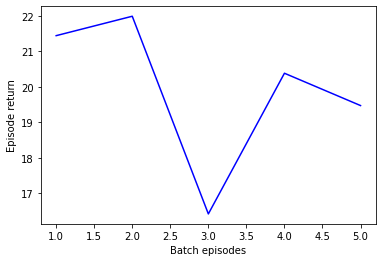

In [35]:
# Executing this code-block defines a new experiment
params = default_params()
params['offpolicy_iterations'] = 128
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(100)
params['batch_size'] = 1000
params['opposd'] = True
params['opposd_iterations'] = 50
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
params['states_shape'] = state_dim
params['num_actions'] = n_actions

# The model has n_action policy heads and one value head
model = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
experiment = ActorCriticExperiment(params, model, learner=OPPOSDLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()